# Time, Pseudotime and MioFlow preparation

Prerequisites:
- You have preprocessed your adata using dimentionaly reduction tools (PCA and PHATE) into the data/preprocessed directory. [notebook: 2-dim-reduction-latent-spaces]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - any extra metadata on _obs_ (ex.: adata.obs['time_label'], adata.obs['disease_progression'], etc...)


In this notebook, we will:
- Use the latent spaces to determine a time features
- In our case, since we have actual time labels, we just need to smooth it using some denoising method.
- In other cases we can use different features to determine pseudotime.
- Finally we will create python objects that are in the format expected by MIOFlow

In [1]:
import phate
import scprep
import pandas as pd
import scanpy as sc

import os

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')

print(PROCESSED_DATA_DIR)

../../data/processed


In [2]:
adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_phate.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

## 1. Retrieve the time feature
In our case the time feature is known and was stored under `adata.obs['time_label']`.

If your data had another feature, like cell_cycle_phase under `adata.obs['cell_cycle']` you can use that as a way to calculate a pseudotime

First, let's verify our current PHATE plot

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

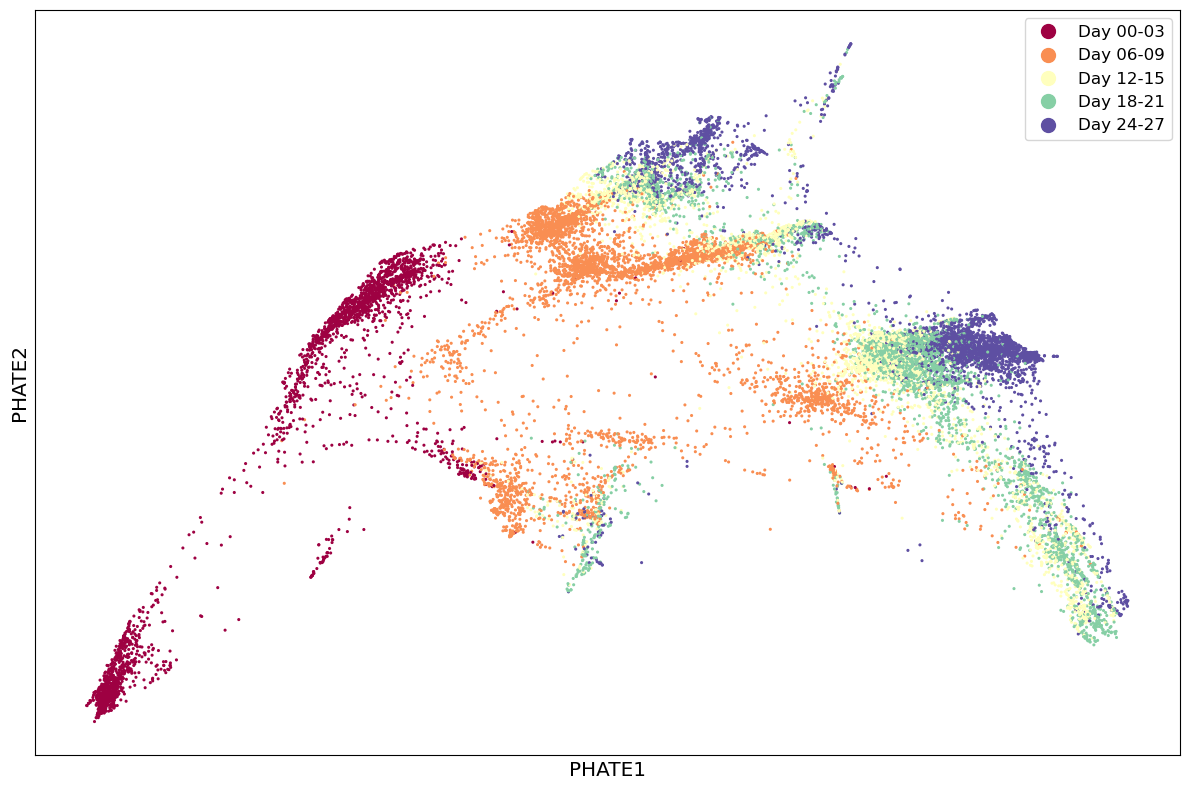

In [3]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['time_label'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# TODO. Reorder.
# 2. [Optional] Inpute a time feature in our data.

Option 1:
- Use MELD to guide your trajectories
- Leiden cluster
- Assign a time label for each cluster (based on your data) (or on guided MELD)


Option 2:
- Diffusion Pseudotime
    - Select a cell as starting point.
    - Returns a smooth time label for every cell on the manifold.

### Runing MELD to smooth the time signal

As we can see, the PHATE plot has some regions where the transition between days is not smooth. We need to denoise this regions.
A solution to this is [MELD](https://github.com/KrishnaswamyLab/MELD) a tool to denoise our data via a binarization mechanism.

Since we know the final points and the initial one on our data, we can binarize our time in order to force a proper state flow.

In [4]:
binary_time = adata.obs['time_label'].isin(['Day 00-03', 'Day 06-09', 'Day 12-15'])

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

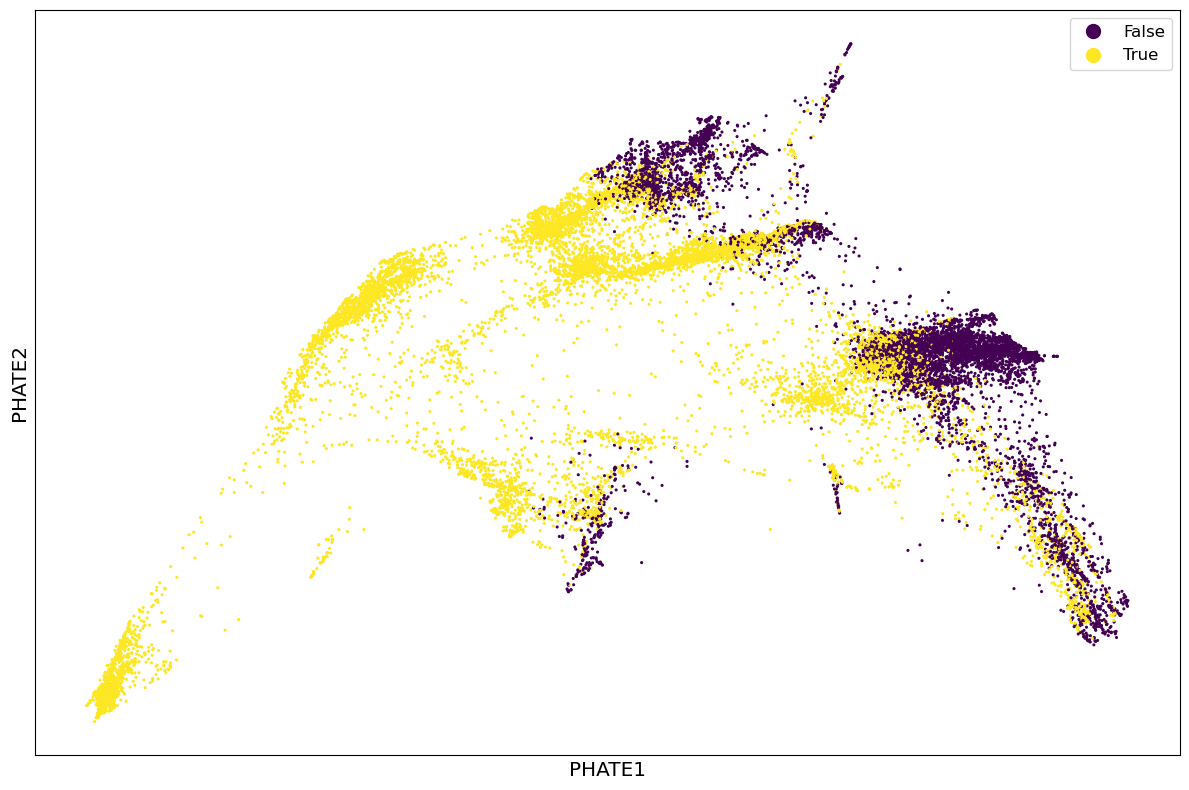

In [5]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=binary_time, figsize=(12,8), cmap="viridis",
                      ticks=False, label_prefix="PHATE")

## Running the MELD operator

In [6]:
import meld
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(adata.obsm['X_phate'], sample_labels=binary_time)
chd_likelihood = meld.normalize_densities(sample_densities)

Building graph on 17944 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.19 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.34 seconds.


/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 15441 and 15502. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


After running, we can now see that our space is smoother, allowing for trajectories to be infered

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

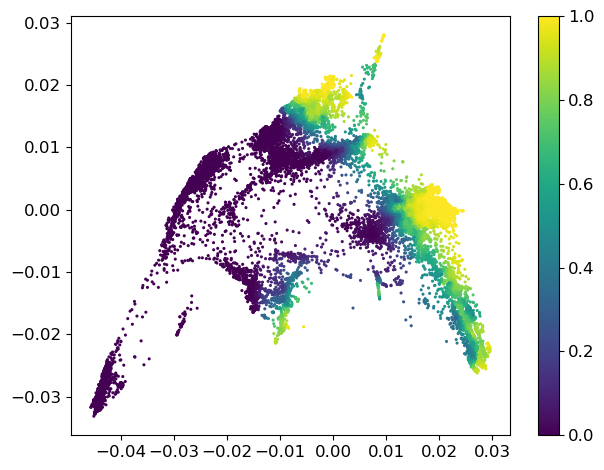

In [7]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=chd_likelihood[False], cmap='viridis')

#### Saving the new MELD objects

In [8]:
adata.obs['pseudotime'] = chd_likelihood[False].to_numpy()
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'pseudotime'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

In [9]:
adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_time.h5ad'))

# 3. Prepare Objects for MIOFlow

In [10]:
RESULTS_DIR = os.path.join('../../results')
os.makedirs(RESULTS_DIR, exist_ok=True)
data_name = 'scRNAseq'
SAVE_PATH = os.path.join(RESULTS_DIR, data_name)
os.makedirs(SAVE_PATH, exist_ok=True)

First, we MIOFlow as described on the [documentation](https://github.com/KrishnaswamyLab/MIOFlow_conditional) needs data to be passed on a specific format:

- Data needs to be passed as pandas DataFrames
- Time labels need to be discrete integer values
- Columns names needs to be d{i} (for every dimension on your data)

### Discretizing time labels

This step can be specific to the way you create the labels.
- If your label is numeric, you can just bin using pd.cut().
- If your label is - like our case - a pd.Categorical() object we can just bin it straight using factorize.

In [11]:
#First we will binarize the time labels
# adata.obs['binarized_time'] = pd.cut(adata.obs['pseudotime'], bins=10, labels=False)

# Create a numerical bin for each unique value
adata.obs['discrete_time'], _ = pd.factorize(adata.obs['time_label'])

### Sanity Check to verify that the discrete times are in the correct order. This is important to properly infer trajectories

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

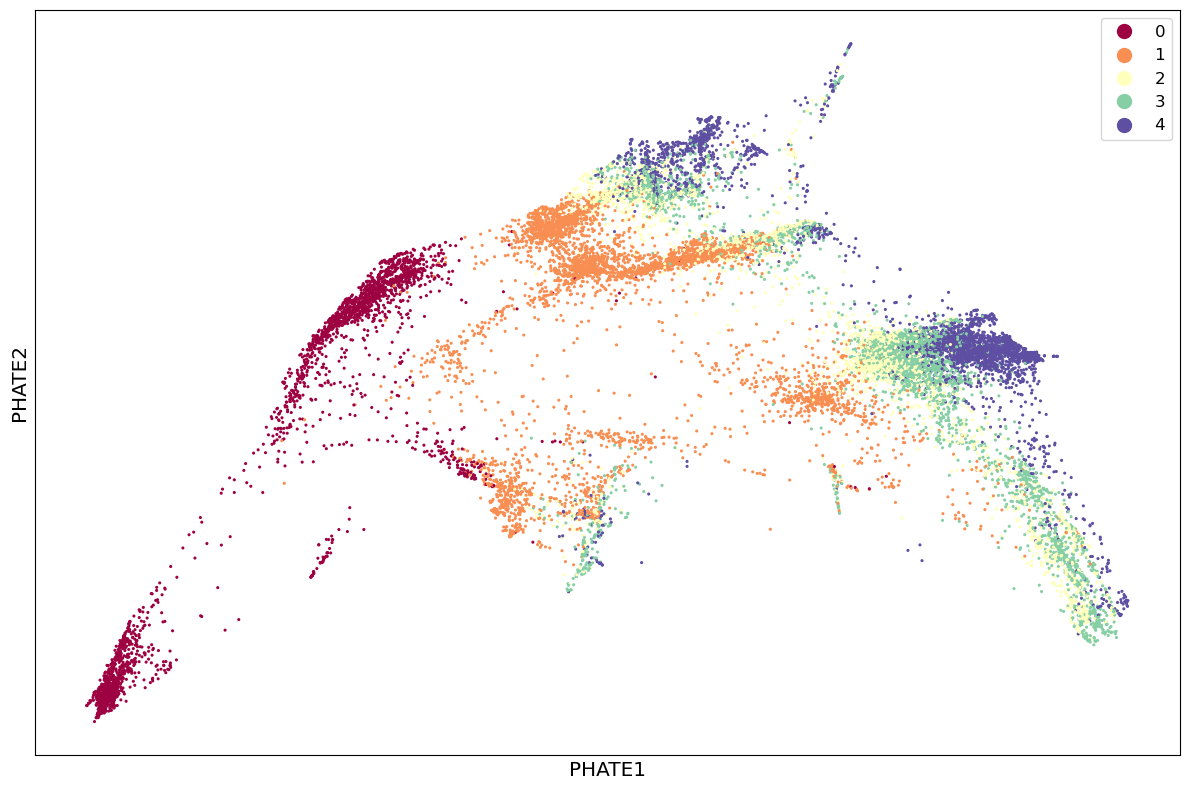

In [21]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['discrete_time'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

Let's verify if all values are assigned in a 

In [12]:
print(adata.obs['discrete_time'].value_counts())

discrete_time
1    4443
3    3910
4    3563
2    3494
0    2534
Name: count, dtype: int64


### Creating the MIOFlow DataFrame

In [13]:
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'pseudotime', 'discrete_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

Here we will simply change the columns names to match the _d{i}_ format expected by MIOFlow and add the discretized samples

In [19]:
adata.obs['time_label']

AAACATTGAAGTGA-1_Day 00-03    Day 00-03
AAACATTGGAGGTG-1_Day 00-03    Day 00-03
AAACATTGGTTTCT-1_Day 00-03    Day 00-03
AAACCGTGCAGAAA-1_Day 00-03    Day 00-03
AAACGCACCGGTAT-1_Day 00-03    Day 00-03
                                ...    
TTTCTACTCTGATG-1_Day 24-27    Day 24-27
TTTCTACTCTTATC-1_Day 24-27    Day 24-27
TTTCTACTTGAGCT-1_Day 24-27    Day 24-27
TTTGCATGATGACC-1_Day 24-27    Day 24-27
TTTGCATGTTCTTG-1_Day 24-27    Day 24-27
Name: time_label, Length: 17944, dtype: category
Categories (5, object): ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']

In [14]:
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])
mioflow_df['samples'] = adata.obs['discrete_time'].values
mioflow_df

,d1,d2,samples
0,-0.037337,-0.015149,0
1,-0.031458,-0.002552,0
2,-0.024888,0.005286,0
3,-0.024332,0.005759,0
4,-0.042807,-0.027289,0
...,...,...,...
17939,0.014323,0.000104,4
17940,0.016775,-0.000934,4
17941,0.022033,-0.000619,4
17942,0.023366,-0.000482,4


### Finally we save the _mioflow_df_ to the results as well as save a new version of our adata object.

In [15]:
mioflow_df.to_csv(os.path.join(SAVE_PATH,'mioflow_data.csv'), index=False)

adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'pseudotime', 'discrete_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'